## Churn prediction in the Energy Sector - Netherlands

In this project we aim to understand the many factors that influence movement of customers from one energy provider to another and in result build a predictive model. The goal is to understand customer churn and predict which customers are most likely to leave and why, ideally, this model would function as a stepping stone into better customer retention.

### For each customer we have the following information:
- ``Customer_ID``: A unique customer identification number.
- ``Gender``: A dummy variable indicating if the customer who signed the contract is male (0) or
female (1).
- ``Age``: The age of the customer in years.
- ``Income``: The monthly income of the customer’s household in euros.
- ``Relation_length``: The amount of months the customer has been with the firm.
- ``Contract_length``: The amount of months the customer still has a contract with the firm. Zero
means the customer has a flexible contract, i.e., (s)he can leave anytime without paying a
fine. If the contract is more than zero months, the customer can still leave, but has to pay a
fine when leaving.
- ``Start_channel``: Indicating if the contract was filled out by the customer on the firm’s website
(“Online”) or by calling up the firm (“Phone”).
- ``Email_list``: Indicating if the customer’s email address is known by the firm (1=yes, 0=no).
- ``Home_age``: The age of the home of the customer in years.
- ``Home_label``: Energy label of the home of the customer, ranging from A (good) to G (bad).
- ``Electricity_usage``: The yearly electricity usage in kWh.
- ``Gas_usage``: The yearly gas usage in cubic meters.
- ``Province``: The province where the customer is living.
- ``Churn``: A dummy variable indicating if the customer has churned (1) or not (0).

## 1. Load Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import shapiro 
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm

In [6]:
os.getcwd()

'/Users/alejandrovillanuevalledo/Documents/GitHub/churn_prediction/Notebook'

In [7]:
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2. Load and visualize data

In [8]:
energy_supplier = pd.read_csv('/Users/alejandrovillanuevalledo/Documents/GitHub/churn_prediction/Dataset/churn_prediction.csv')

In [9]:
energy_supplier.head()

Customer_ID  Gender  Age  Income  Relation_length  Contract_length  \
0            1       0   37    2371               50                0   
1            2       1   49    4534               22                0   
2            3       1   53    5279               67                7   
3            4       1   40    4404               40                0   
4            5       1   70    2144               74               31   

  Start_channel  Email_list  Home_age Home_label  Electricity_usage  \
0        Online           1        17          F               2238   
1        Online           0        11          E               3306   
2        Online           1        31          E               2664   
3        Online           1        12          D               2870   
4        Online           1        28          F               2983   

   Gas_usage       Province  Churn  
0       1425  Noord-Brabant      1  
1       1651  Noord-Holland      1  
2       1176     Gelderland      0  
3       1899   Zuid-Holland      1  
4       1120  Noord-Brabant      1

No null values
Number of duplicates: 0


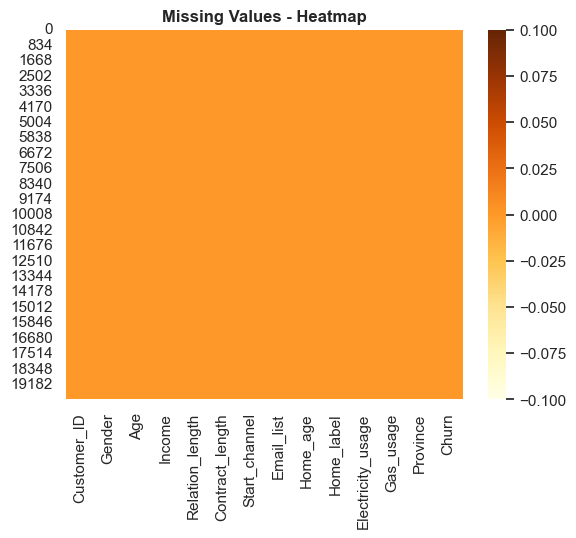

In [10]:
#missing values heatmap
nulls = energy_supplier.isnull().sum()
sns.set(rc={'figure.facecolor':'none'}) #set background to be transparent
sns.heatmap(energy_supplier.isnull(), cmap='YlOrBr')
plt.title('Missing Values - Heatmap', fontweight='bold')

#we print the missing values per column if there are missing values, or no null values otherwise
if nulls.any() > 0 :
    print(nulls)
else:
    print('No null values')

#We check for duplicated rows 
print('Number of duplicates:',energy_supplier.duplicated().sum())


The dataset has no missing values or duplicates

In [11]:
energy_supplier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Customer_ID        20000 non-null  int64 
 1   Gender             20000 non-null  int64 
 2   Age                20000 non-null  int64 
 3   Income             20000 non-null  int64 
 4   Relation_length    20000 non-null  int64 
 5   Contract_length    20000 non-null  int64 
 6   Start_channel      20000 non-null  object
 7   Email_list         20000 non-null  int64 
 8   Home_age           20000 non-null  int64 
 9   Home_label         20000 non-null  object
 10  Electricity_usage  20000 non-null  int64 
 11  Gas_usage          20000 non-null  int64 
 12  Province           20000 non-null  object
 13  Churn              20000 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 2.1+ MB


In [12]:
#print number of unique values and the variable type per column 
for column in energy_supplier:
    print(column,':')
    print(energy_supplier[column].nunique(),',', energy_supplier[column].dtype)

Customer_ID :
20000 , int64
Gender :
2 , int64
Age :
88 , int64
Income :
8098 , int64
Relation_length :
226 , int64
Contract_length :
37 , int64
Start_channel :
2 , object
Email_list :
2 , int64
Home_age :
201 , int64
Home_label :
7 , object
Electricity_usage :
2840 , int64
Gas_usage :
2565 , int64
Province :
12 , object
Churn :
2 , int64


## 3. Data Cleaning and Preprocessing

### 3.1 Column formatting and Data transformation

In [13]:
#lowercase the column names
energy_supplier.columns = energy_supplier.columns.str.lower()

In [14]:
#turn categorical variables categorical 
#energy_supplier['gender']= energy_supplier['gender'].astype('category') I leave gender as num for the correlation plot
energy_supplier['start_channel']= energy_supplier['start_channel'].astype('category')
energy_supplier['email_list']= energy_supplier['email_list'].astype('category')
energy_supplier['home_label']= energy_supplier['home_label'].astype('category')
energy_supplier['province']= energy_supplier['province'].astype('category')

Income is given in monthly €, when modelling the effect of 1€ increase in income might be hard to interpret or be insignificant, however, percentual changes in income could make more sense on churn effect. We create a new variable 'log_income' to determine whether single euro units or percentage changes are more significant in predicting customer churn.

In [15]:
#we create log of income
energy_supplier['log_income'] = np.log(energy_supplier['income'])

I will use Label Encoder, for some of the other categorical variables that follow a certain order, as it is home label, and other that don't (start channel). This will help when studying correlation between variables, as well as with modelling 

In [16]:
#an instance of label encoder is created, the fitted encoder is used to tranform the home label variable
encoder = LabelEncoder()
encoded_data = encoder.fit_transform(energy_supplier[['home_label']])
#this simply returns an array 
#here we turn the encoded data into an actual dataframe with a column name 
onehot_name_df = pd.DataFrame(data=encoded_data, columns=['home_label'])
energy_supplier['e_home_label'] = pd.DataFrame(data=encoded_data, columns=['home_label'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
encoder = LabelEncoder()
encoded_data = encoder.fit_transform(energy_supplier[['start_channel']])
#this simply returns an array 
#here we turn the encoded data into an actual dataframe with a column name 
onehot_name_df = pd.DataFrame(data=encoded_data, columns=['start_channel'])
energy_supplier['e_start_channel'] = pd.DataFrame(data=encoded_data, columns=['start_channel'])
#online = 0, phone = 1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 3.2 Dealing with Outliers

Dataframe subset creation with metric variables, we log transformed them to equalize variances, useful when comparing variables with different scales

In [18]:
num_variables_df = np.log(energy_supplier.select_dtypes(include=['int64', 'float64']).drop(columns= ['customer_id','churn','e_home_label', 'e_start_channel']))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


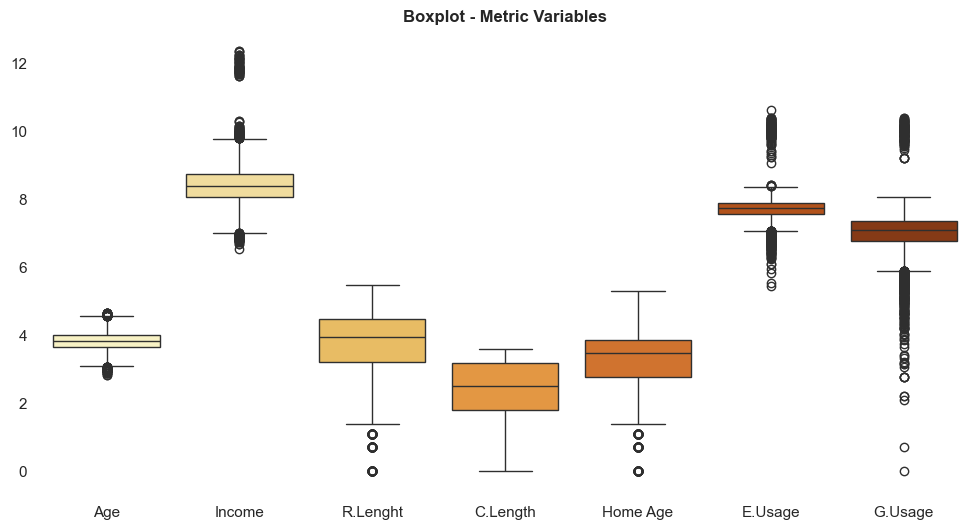

In [19]:
#Boxplots to detect outliers
plt.figure(figsize= (12,6))
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
sns.boxplot(num_variables_df.drop(columns=['log_income', 'gender']), palette='YlOrBr')
plt.title('Boxplot - Metric Variables', fontweight = 'bold')
plt.xticks(np.arange(0,7), ['Age','Income','R.Lenght','C.Length', 'Home Age', 'E.Usage','G.Usage'])
plt.gca().set_facecolor('none')#set boxplot background to be transparent

Income, electricity usage and gas usage have the larger number of outliers, aditionally, we can also see sudden jump in all three variables in the upper quartile. Let's study this in more depth. 

#### 3.2.1 Income Outliers

Axes(0.125,0.11;0.775x0.77)


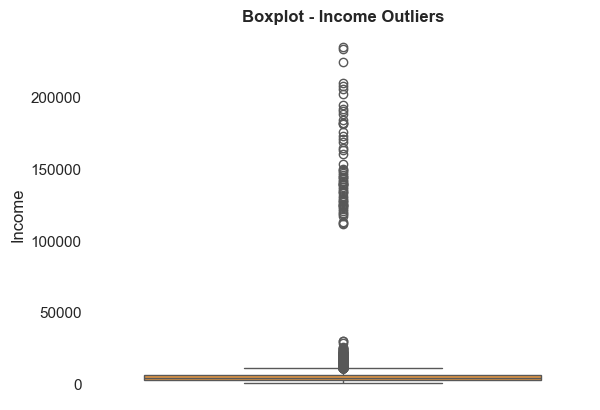

In [20]:
print(sns.boxplot(energy_supplier['income'], palette='YlOrBr'))
plt.ylabel('Income')
plt.title('Boxplot - Income Outliers', fontweight = 'bold')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent

In [21]:
#This function detects outliers in a given column and returns a list of outliers
def upper_outliers (column_data):
    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    upper_outliers = [x for x in column_data if x > upper_bound]
    
    return sorted(upper_outliers)

outliers_income = upper_outliers(energy_supplier['income'])

In [22]:
for x in outliers_income:
    if  30000 < x < 150000:
        print(x)

30042
112130
112580
113020
117240
118980
119850
121160
122420
123600
124510
124810
124970
125680
127110
128160
128710
130080
131260
133500
134400
134900
136500
137550
139380
139480
139960
139990
141260
142250
143020
144410
144810
146170
147720
149120
149700


A steep increase can be seen in income above 30042€, the income variable is indicative of a customers monthly income. It is believed that the odd numbers come from customers inputting their yearly income instead. To fix it outliers above 50000€ will be divided by 12 to achieve monthly income.

In [23]:
#Lambda function to substitute outliers in income
energy_supplier['income'] = energy_supplier['income'].apply(lambda x: x / 12 if x > 50000 else x)

In [24]:
'''
energy_supplier['income'] = np.where(energy_supplier['income'] > 50000,
                                     energy_supplier['income'] / 12,
                                     energy_supplier['income']
'''

"\nenergy_supplier['income'] = np.where(energy_supplier['income'] > 50000,\n                                     energy_supplier['income'] / 12,\n                                     energy_supplier['income']\n"

#### 3.2.2 Electricity and Gas Outliers

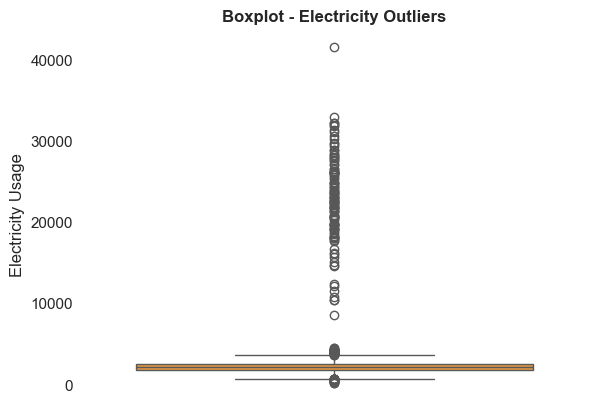

In [25]:
sns.boxplot(energy_supplier['electricity_usage'], palette='YlOrBr')
plt.ylabel('Electricity Usage')
plt.title('Boxplot - Electricity Outliers', fontweight = 'bold')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent


Axes(0.125,0.11;0.775x0.77)


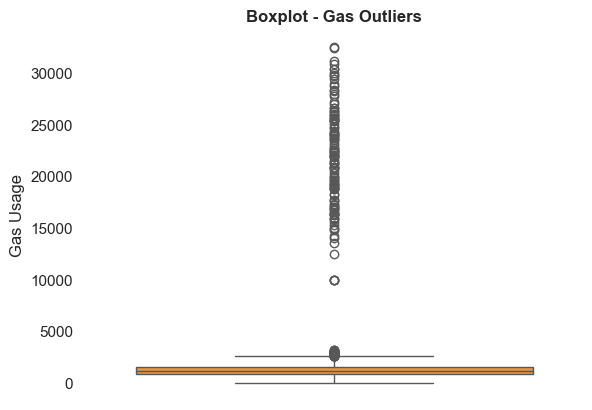

In [26]:
print(sns.boxplot(energy_supplier['gas_usage'], palette='YlOrBr'))
plt.ylabel('Gas Usage')
plt.title('Boxplot - Gas Outliers', fontweight = 'bold')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent

In [27]:
#The jump is found at 8610 KWh per year and 3209 cubic meters per year
outliers_eusage = upper_outliers(energy_supplier['electricity_usage'])
outliers_gas = upper_outliers(energy_supplier['gas_usage'])

For both electricity usage and gas usage the outlier can be due to a misreading of the consumption meters, mistakinly adding an extra 0 at the end of the level of consumption. Outliers in both variables will be divided by 10. 

In [28]:
energy_supplier['electricity_usage'] = energy_supplier['electricity_usage'].apply(lambda x: x / 10 if x > 8000 else x)
energy_supplier['gas_usage'] = energy_supplier['gas_usage'].apply(lambda x: x / 10 if x > 5000 else x)

In [29]:
energy_supplier.drop(columns=['e_start_channel','e_home_label','log_income']).to_csv('churn_azure_df.csv', index=False)

## 4. Exploratory Data Analysis

In [24]:
energy_supplier.drop(columns='customer_id').describe().T

count         mean          std         min          25%  \
gender             20000.0     0.502400     0.500007    0.000000     0.000000   
age                20000.0    47.703600    13.285905   17.000000    38.000000   
income             20000.0  5113.190525  2876.350888  684.000000  3146.000000   
relation_length    20000.0    59.508950    42.548459    0.000000    25.000000   
contract_length    20000.0     8.951250    10.784841    0.000000     0.000000   
home_age           20000.0    38.455850    33.505020    0.000000    16.000000   
electricity_usage  20000.0  2277.232250   546.016087  231.000000  1903.000000   
gas_usage          20000.0  1210.203950   528.380912    0.000000   846.000000   
churn              20000.0     0.490100     0.499914    0.000000     0.000000   
log_income         20000.0     8.411358     0.550452    6.527958     8.053887   
e_home_label       20000.0     3.179750     1.821622    0.000000     2.000000   
e_start_channel    20000.0     0.179950     0.384155    0.000000     0.000000   

                           50%          75%           max  
gender                1.000000     1.000000      1.000000  
age                  46.000000    55.000000    104.000000  
income             4451.000000  6302.000000  30042.000000  
relation_length      51.000000    87.000000    241.000000  
contract_length       5.000000    15.000000     36.000000  
home_age             31.000000    47.000000    200.000000  
electricity_usage  2261.000000  2638.000000   4578.000000  
gas_usage          1180.000000  1553.250000   3257.000000  
churn                 0.000000     1.000000      1.000000  
log_income            8.400884     8.748622     12.368829  
e_home_label          3.000000     5.000000      6.000000  
e_start_channel       0.000000     0.000000      1.000000

Here we see some interesting descriptives, e.g. the average customer is middle-aged and they have a realtively long-standing relationship with the company averaging on almost 5 years, significant compared to the 8 months of average on the contract length. 
Finally, the dataset is well balanced with the target variable 'Churn' being close to a 50-50 of customers having churned vs having remained in the company

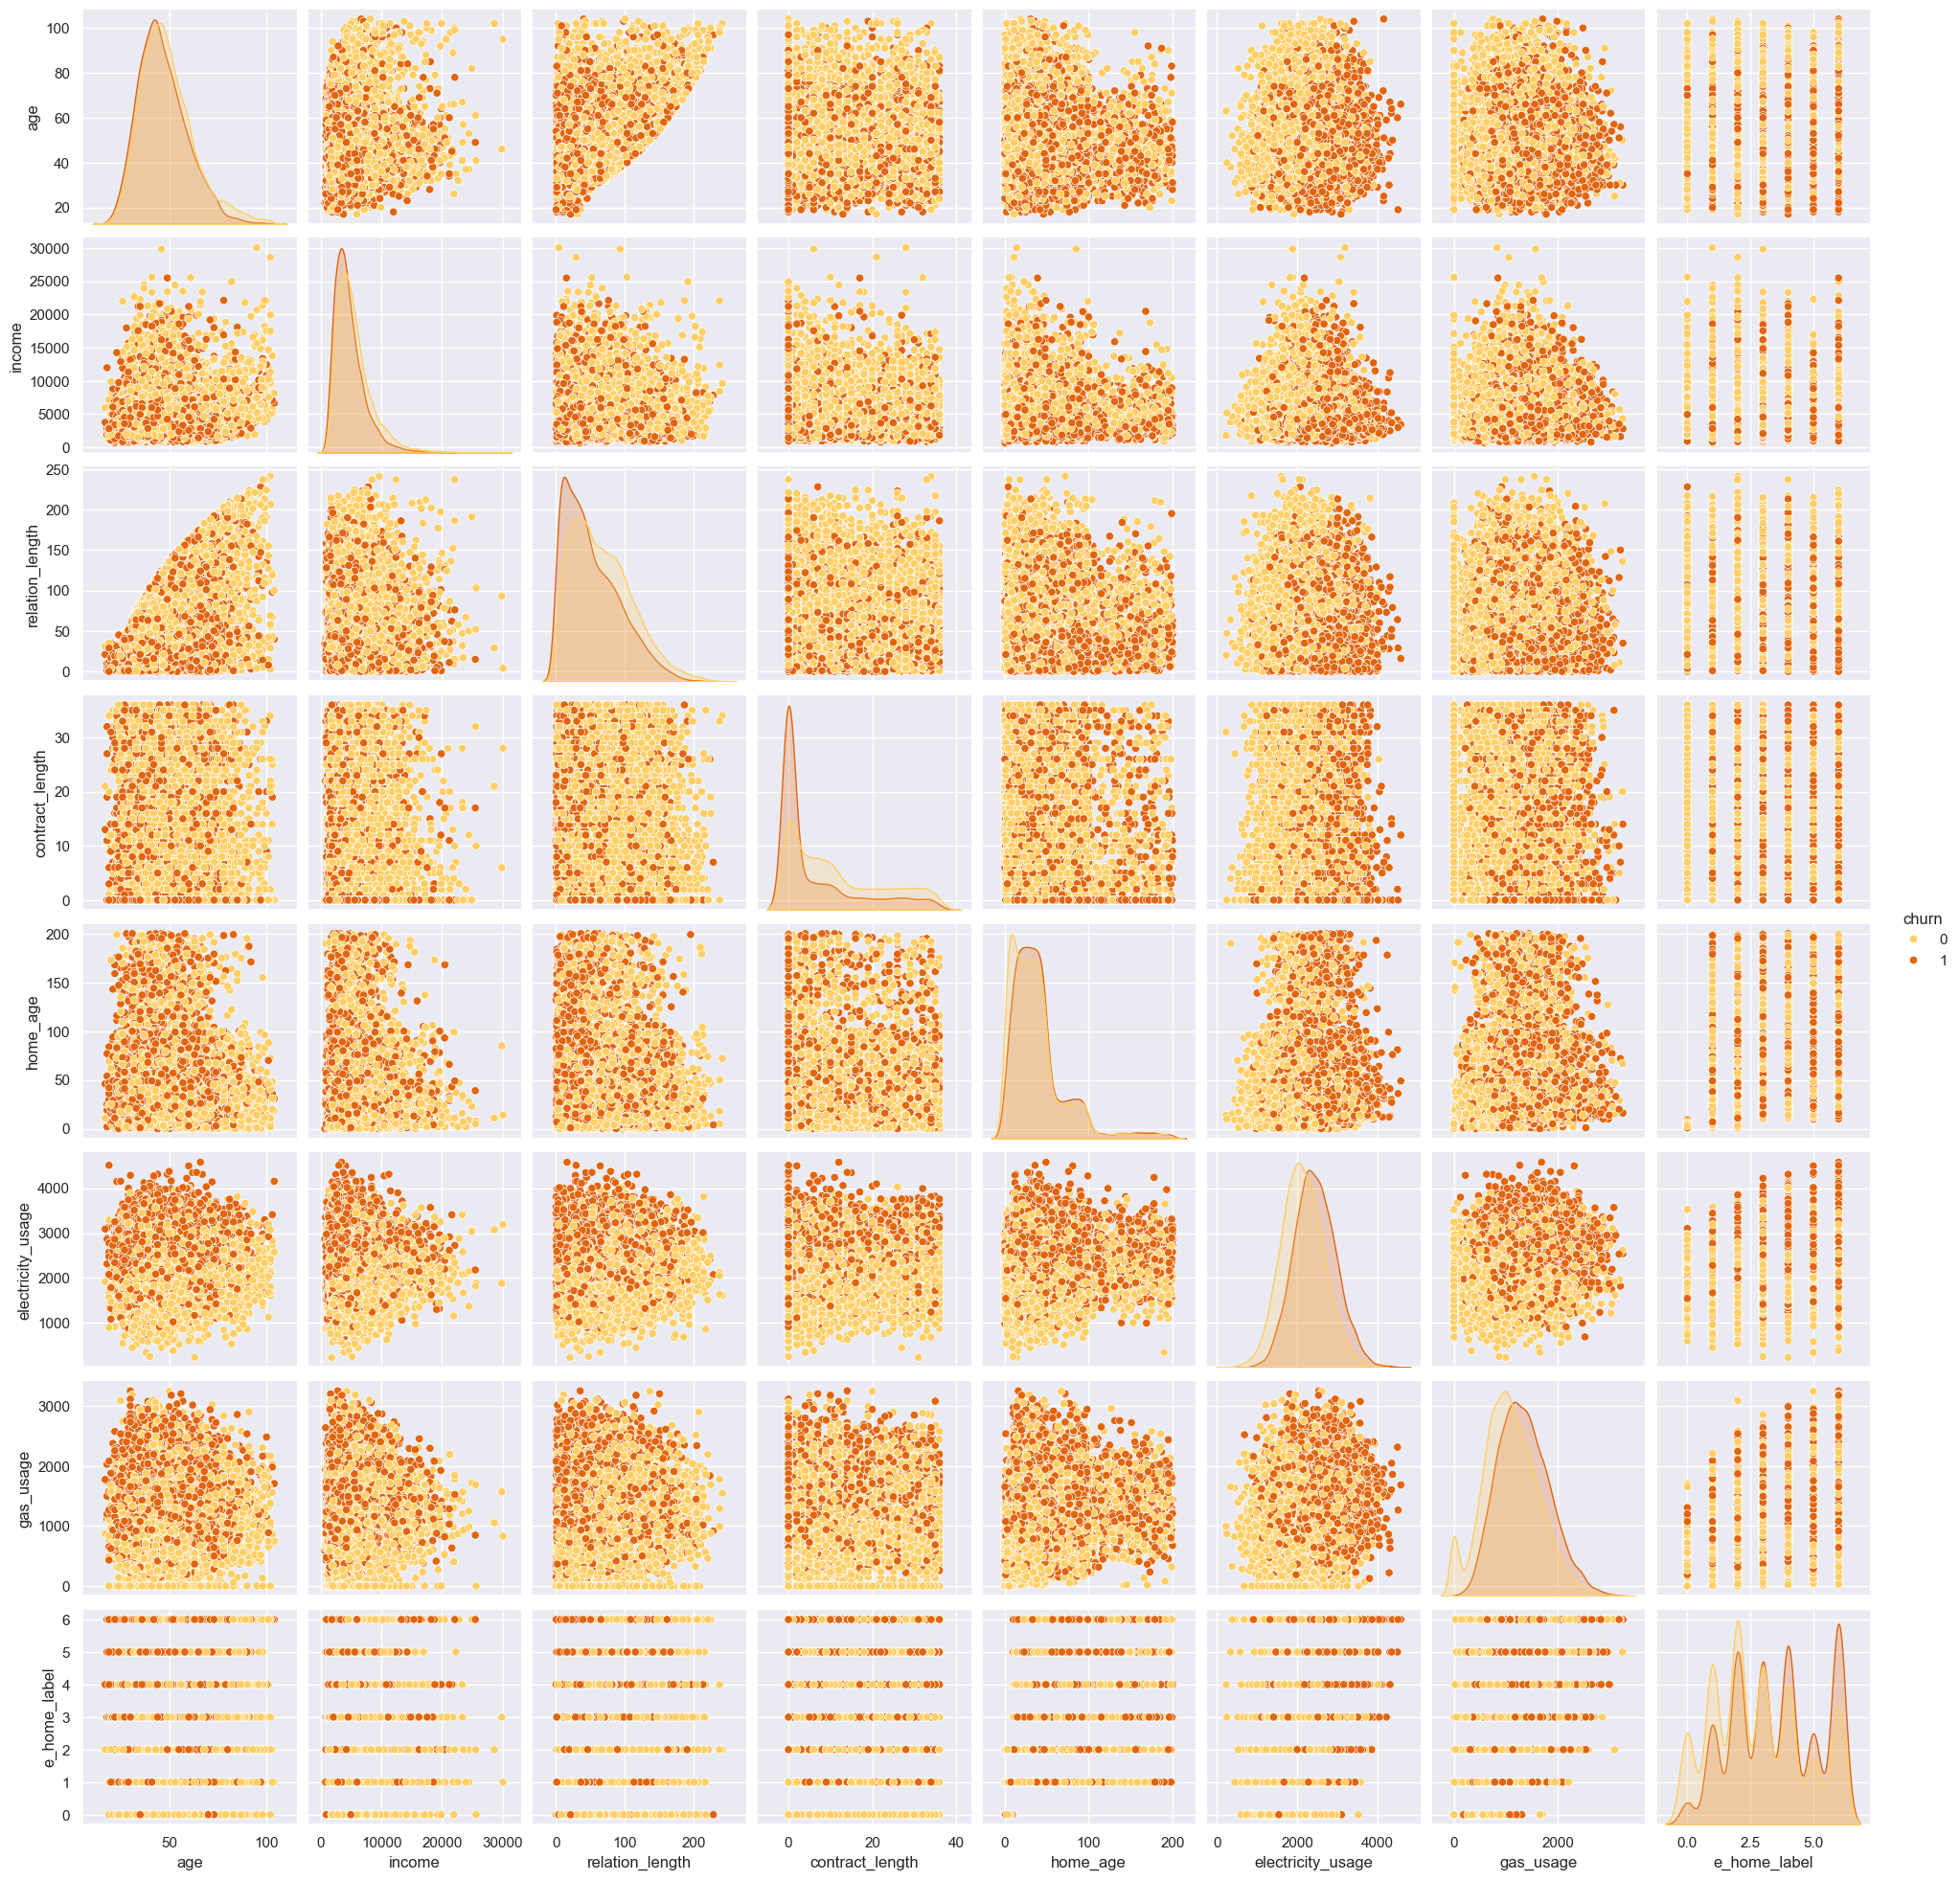

In [25]:
sns.pairplot(energy_supplier.drop(columns=['customer_id', 'log_income','e_start_channel', 'gender']), hue='churn', palette='YlOrBr')

Although quite a bit of information is presented, a few things caught my eye: 
- Age and relationship length seem to be positively correlated 
- Home label, gas usage and electricity usage seem to be correlated
- Contract's length histogram has a large number of ocurrences close to 0 
- Home's age histogram has three distinct level drops 

A deeper dive will be done into these variables

/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_34476/897103776.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = energy_supplier.drop(columns=['customer_id','log_income']).corr(method = 'pearson').sort_values(by = 'churn', axis = 0, ascending = False).sort_values(by = 'churn', axis = 1, ascending = False)


<Axes: >

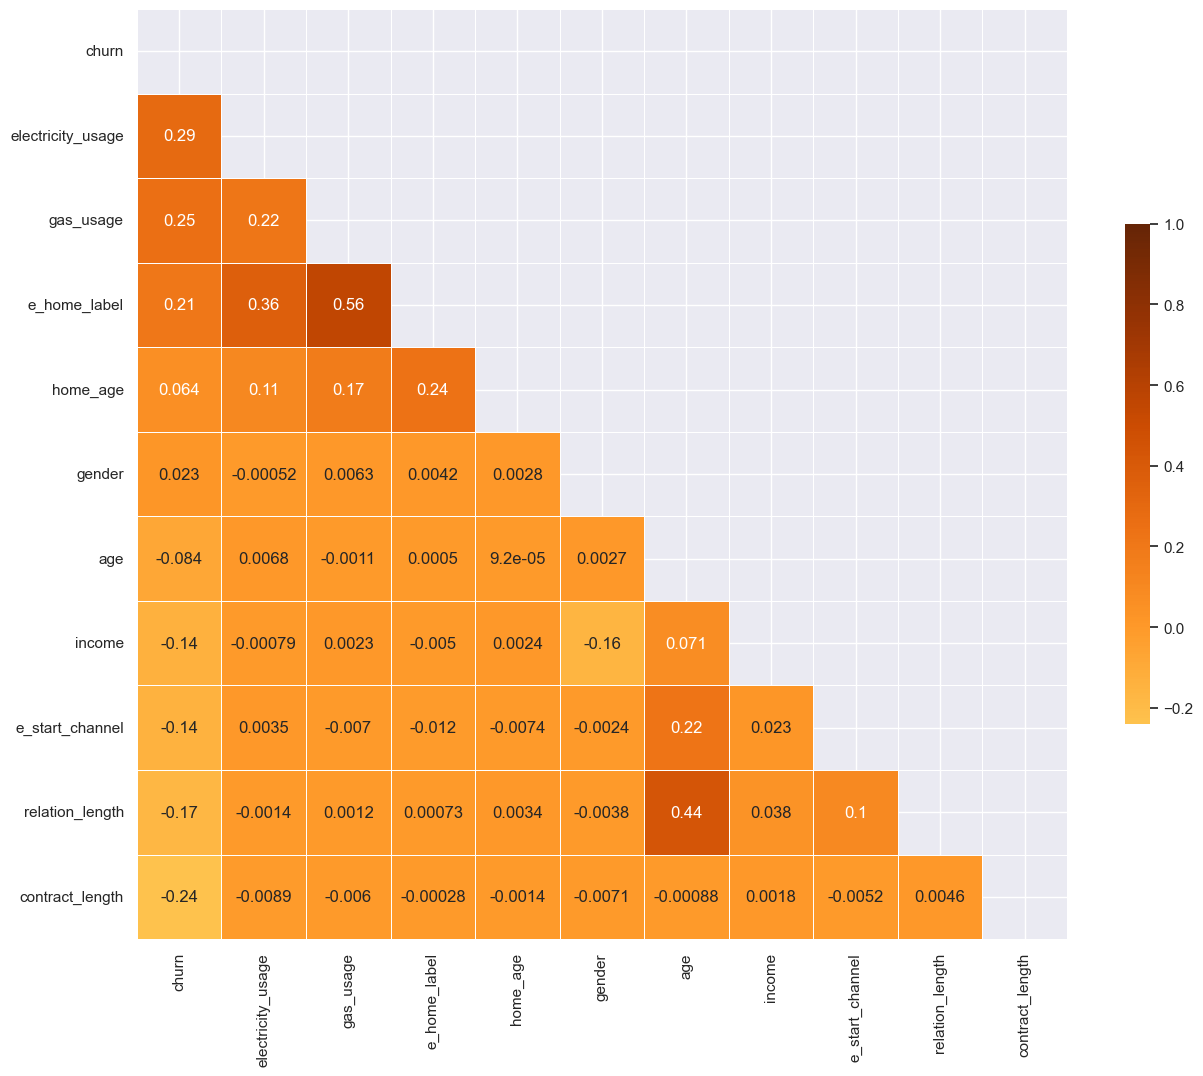

In [26]:
corr = energy_supplier.drop(columns=['customer_id','log_income']).corr(method = 'pearson').sort_values(by = 'churn', axis = 0, ascending = False).sort_values(by = 'churn', axis = 1, ascending = False)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,13))

# Generate a custom diverging colormap
cmap = sns.color_palette("YlOrBr", as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.iloc[0:11,0:11], mask=mask[0:11,0:11], cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

In this correlation heatmap: 

- Positive correlation:
    - Age and relationship length, as we had expected from the previuous graph
    - Slight positive correlation between electricity and gas usage with churn, similarly between home label and churn, which can be explained by 
      the high correlation between electricity and gas usage with home label.
    - Gas and electricity usage 
    - Gas usage and home age
    - Positive correlation between age and start channel, since phone is 1 in this case, it can be expected that older people prefer        communication through the phone rather than online

- Negative correlation:
    - Slight negative correlation between income, relationship lenght, start_channel and contract length with churn 


### 4.1 Contract Length

Text(0.5, 0, 'Contract Length')

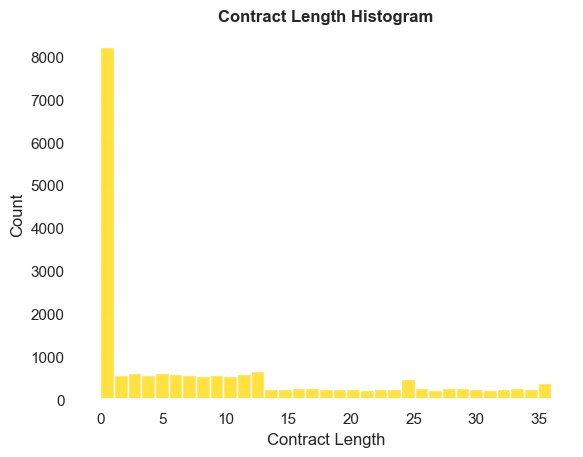

In [27]:
sns.histplot(energy_supplier['contract_length'], color='#FFD700')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent
plt.title('Contract Length Histogram', fontweight='bold')
plt.xlabel('Contract Length')

Due to the large number of 0s in this variable, we create a new binary variable 'contract' to determine the possible effect of switching costs

In [28]:
energy_supplier['contract'] = np.where(energy_supplier['contract_length'] > 0, 
                                       1,
                                       0)

### 4.2 Home Age

Text(0.5, 0, 'Home Age')

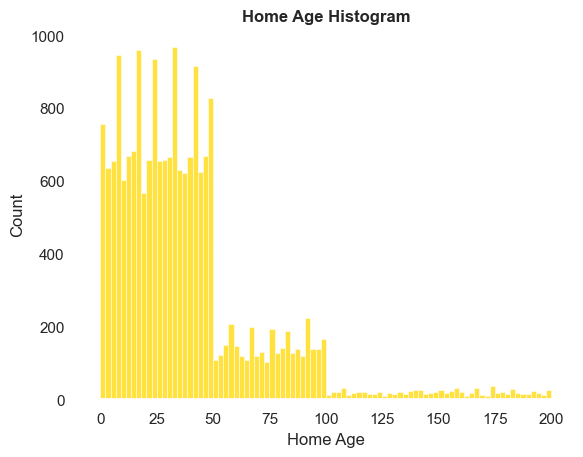

In [29]:
sns.histplot(energy_supplier['home_age'], color='#FFD700')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent
plt.title('Home Age Histogram', fontweight='bold')
plt.xlabel('Home Age')

Here we can also see three distinct levels at home's age, from 0 to 50 years old, 50 to 100 and 100 years and older. We turn this variable categorical. 

In [30]:
#we define a function to categorize home's age 
def home_age_category(age):
    if age <= 50:
        return '0-50'
    elif age <= 100:
        return '50-100'
    else:
        return '100+'

#we apply the function 
energy_supplier['home_age_c'] = energy_supplier['home_age'].apply(home_age_category)

#and we turn the variable categorical 
energy_supplier['home_age_c'] = pd.Categorical(energy_supplier['home_age_c'])

### 4.3 Correlation Deep Dive

#### 4.3.1 Relationship Length and Age

In [31]:
print('Shapiro Result for relationship length:' ,shapiro(energy_supplier['relation_length']))

Shapiro Result for relationship length: ShapiroResult(statistic=0.9435011368328781, pvalue=9.084847305520604e-65)


/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_34476/756482111.py:1: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20000.
  print('Shapiro Result for relationship length:' ,shapiro(energy_supplier['relation_length']))


In [32]:
print('Shapiro Result for Age :' ,shapiro(energy_supplier['age']))

Shapiro Result for Age : ShapiroResult(statistic=0.9640185462381221, pvalue=5.134970449645249e-56)


/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_34476/2745659874.py:1: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20000.
  print('Shapiro Result for Age :' ,shapiro(energy_supplier['age']))


In [33]:
from scipy.stats import normaltest
stat, p_value = normaltest(energy_supplier['relation_length'])
print("D'Agostino-Pearson test p-value:", p_value)

D'Agostino-Pearson test p-value: 0.0


In [34]:
stat, p_value = normaltest(energy_supplier['age'])
print("D'Agostino-Pearson test p-value:", p_value)

D'Agostino-Pearson test p-value: 0.0


Both p-values < .05 in the Shapiro test and D'Angostino-Pearson Test, therefore, there is a significant difference from a normal distribution. I'll be using Spearman's correlation coefficient

In [35]:
#we check if the correlation is significant
corr, p_value = spearmanr(energy_supplier['age'], energy_supplier['relation_length'])
#p-value < 0.05, therefore, significant positive correlation between both variables 

Text(0, 0.5, 'Relationship Length')

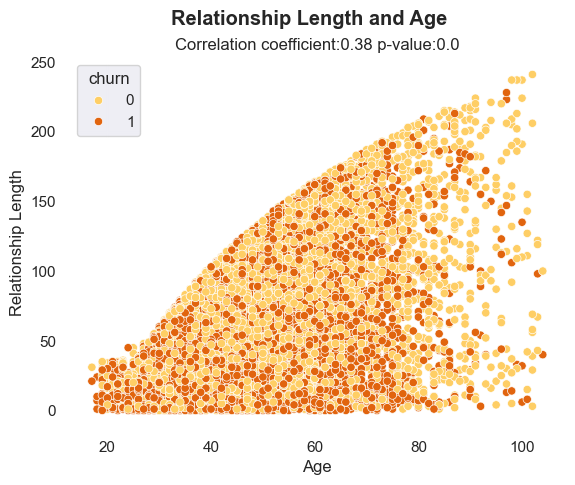

In [36]:
sns.scatterplot(energy_supplier, x='age', y='relation_length',  palette='YlOrBr', hue= 'churn')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent
plt.suptitle('Relationship Length and Age', fontweight='bold')
plt.title('Correlation coefficient:' + '{:.2f}'.format(corr) + ' p-value:' + str(p_value))
plt.xlabel('Age')
plt.ylabel('Relationship Length')

#### 4.3.2 Electricity and Gas consumption

In [37]:
stat, p_value = normaltest(energy_supplier['electricity_usage'])
print("D'Agostino-Pearson test p-value:", p_value)

D'Agostino-Pearson test p-value: 1.0487271693786452e-14


In [38]:
stat, p_value = normaltest(energy_supplier['gas_usage'])
print("D'Agostino-Pearson test p-value:", p_value)

D'Agostino-Pearson test p-value: 7.537437360978059e-38


Variables do not follow a normal distribution, Spearman correlation coefficient will be used again

In [39]:
spearmanr(energy_supplier['electricity_usage'], energy_supplier['gas_usage'])

SignificanceResult(statistic=0.21830526989388468, pvalue=2.3239141702016248e-214)

These two variables also seem to have a positive significant correlation, which to me goes against face validity

<Axes: xlabel='electricity_usage', ylabel='gas_usage'>

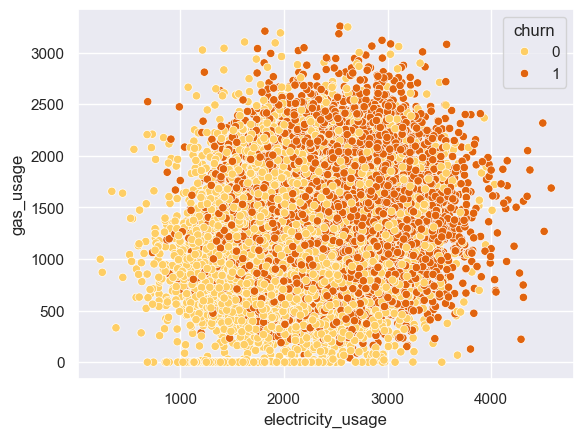

In [40]:
sns.scatterplot(energy_supplier, x='electricity_usage', y='gas_usage',  palette='YlOrBr', hue= 'churn')

#### 4.3.2 Age and Start Channel

In [41]:
age_online = energy_supplier[energy_supplier['start_channel']=='Online'][['age']]
age_phone = energy_supplier[energy_supplier['start_channel']=='Phone'][['age']]

In [42]:
#we check for normality
stat, p_value_income = normaltest(energy_supplier['age'])
print("D'Agostino-Pearson test p-value:", p_value_income)

D'Agostino-Pearson test p-value: 0.0


Age does not follow a normal distribution

In [43]:
print("Mann-Whitney U test for electricity usage:", mannwhitneyu(age_online, age_phone))

Mann-Whitney U test for electricity usage: MannwhitneyuResult(statistic=array([23642924.5]), pvalue=array([3.25100285e-78]))


Averages are significantly different

/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_34476/1813224477.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=energy_supplier, x="start_channel", y="age", kind="box",  palette='YlOrBr')


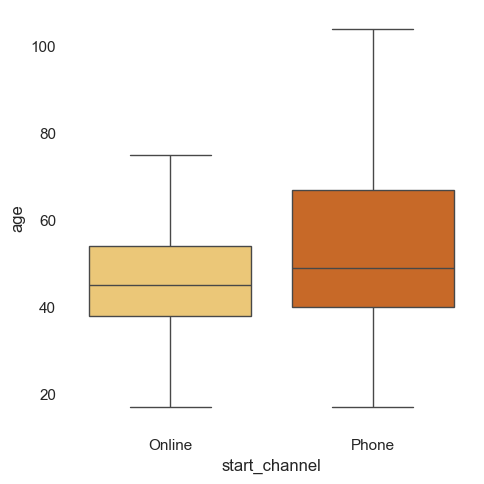

In [44]:
sns.catplot(data=energy_supplier, x="start_channel", y="age", kind="box",  palette='YlOrBr')
plt.gca().set_facecolor('none')#set boxplot background to be transparent
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent

#### 4.3.3 Home Label and Home Age

In [45]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the ANOVA model
model = ols('home_age ~ C(home_label)', data=energy_supplier).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)
if anova_table['PR(>F)'][0] > 0.05:
	print('No significant effect on home age')
else:
	print('Significant effect on home age')


                     sum_sq       df           F  PR(>F)
C(home_label)  2.237002e+06      6.0  368.764652     0.0
Residual       2.021360e+07  19993.0         NaN     NaN
Significant effect on home age


In [46]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(energy_supplier['home_age'], energy_supplier['home_label'])

# Print the summary of the test results
print(tukey_results.summary())


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B  22.4014    0.0 19.1948 25.6081   True
     A      C  33.3037    0.0 30.2528 36.3547   True
     A      D  40.9061    0.0 37.7932  44.019   True
     A      E  38.5738    0.0 35.4549 41.6928   True
     A      F  39.4419    0.0 35.9195 42.9643   True
     A      G  40.6938    0.0 37.5753 43.8124   True
     B      C  10.9023    0.0  8.5981 13.2065   True
     B      D  18.5047    0.0 16.1191 20.8903   True
     B      E  16.1724    0.0  13.779 18.5658   True
     B      F  17.0404    0.0 14.1407 19.9402   True
     B      G  18.2924    0.0 15.8994 20.6853   True
     C      D   7.6024    0.0  5.4305  9.7743   True
     C      E   5.2701    0.0  3.0896  7.4506   True
     C      F   6.1381    0.0  3.4115  8.8648   True
     C      G   7.3901    0.0  5.2101  9.5701   True
     D      E  -2.3323 0.0389 -4.5986 -0.0659 

Based on the Tukey Test, the average home age for labels A, B and C are significantly different from each other and the rest of the labels, however, from level D onwards the age differences are not significant anymore. 

/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_34476/1623687671.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='home_label', y='home_age', data=energy_supplier,  palette='YlOrBr')


Text(0, 0.5, 'Home Age')

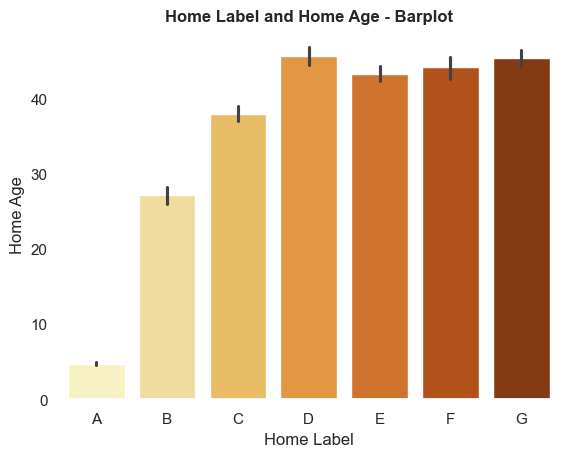

In [47]:
sns.barplot(x='home_label', y='home_age', data=energy_supplier,  palette='YlOrBr')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent
plt.title('Home Label and Home Age - Barplot', fontweight='bold')
plt.xlabel('Home Label')
plt.ylabel('Home Age')

#### 4.3.4 Churn - Electricity and Gas Consumption

Since we already now that electricity and gas usage do not follow a normal distribution a Mann Whitney U test will be perform as a method for comparing means

In [49]:
churned_electricity = energy_supplier[energy_supplier['churn']==1][['electricity_usage']]
not_churned_electricity = energy_supplier[energy_supplier['churn']==0][['electricity_usage']]
churned_gas = energy_supplier[energy_supplier['churn']==1][['gas_usage']]
not_churned_gas = energy_supplier[energy_supplier['churn']==0][['gas_usage']]

In [50]:
print("Mann-Whitney U test for electricity usage:", mannwhitneyu(churned_electricity, not_churned_electricity))
print("Mann-Whitney U test for gas usage:", mannwhitneyu(churned_gas, not_churned_gas))

Mann-Whitney U test for electricity usage: MannwhitneyuResult(statistic=array([66649116.5]), pvalue=array([0.]))
Mann-Whitney U test for gas usage: MannwhitneyuResult(statistic=array([63995583.]), pvalue=array([2.26978457e-258]))


p-values < .05 - We reject Ho, therefore, average electricity and gas usage on those who churned and stayed are significantly different

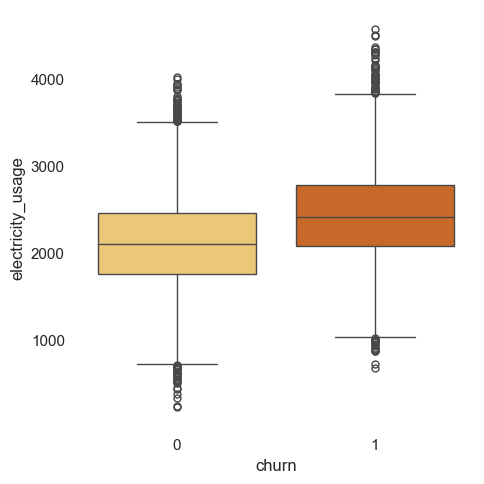

In [51]:
sns.catplot(data=energy_supplier, x="churn", y="electricity_usage", kind="box",  palette='YlOrBr')
plt.gca().set_facecolor('none')#set boxplot background to be transparent
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent

<Axes: xlabel='electricity_usage', ylabel='Count'>

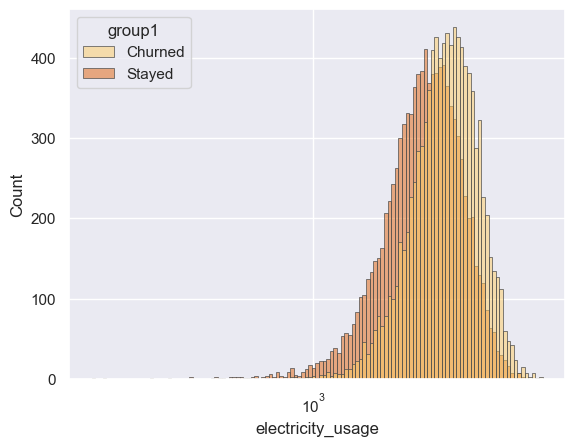

In [52]:
# Graph
energy_supplier['group1'] = energy_supplier['churn'].apply(lambda x: 'Churned' if x in [1] else 'Stayed')
sns.histplot(
    energy_supplier.loc[energy_supplier['electricity_usage']>0,:],
    x="electricity_usage", hue="group1",
    multiple="layer",
    palette="YlOrBr",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,)

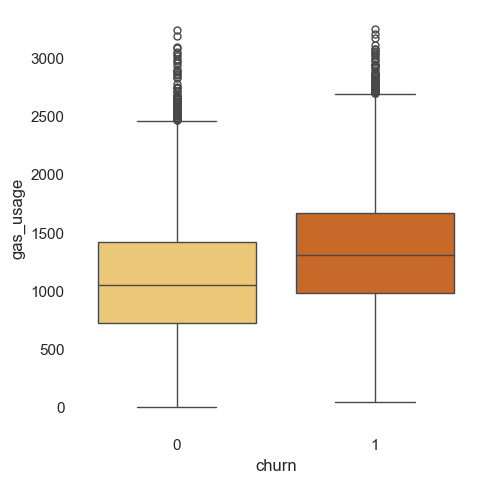

In [53]:
sns.catplot(data=energy_supplier, x="churn", y="gas_usage", kind="box", palette='YlOrBr')
plt.gca().set_facecolor('none')#set boxplot background to be transparent)
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent

<Axes: xlabel='gas_usage', ylabel='Count'>

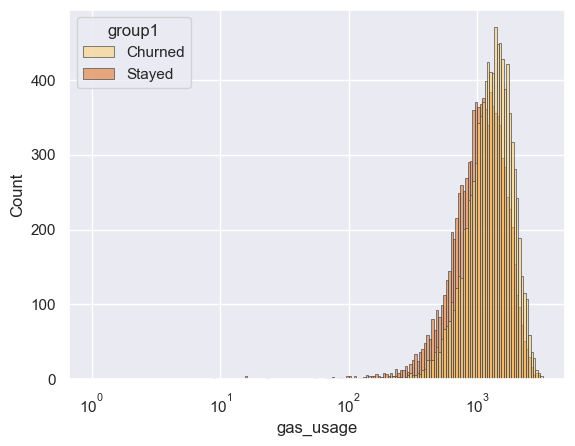

In [54]:
# Graph
energy_supplier['group1'] = energy_supplier['churn'].apply(lambda x: 'Churned' if x in [1] else 'Stayed')
sns.histplot(
    energy_supplier.loc[energy_supplier['gas_usage']>0,:],
    x="gas_usage", hue="group1",
    multiple="layer",
    palette="YlOrBr",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,)

As we can see in the graphs, customers with higher volumes of electricity and gas usage on average seem to churn than those who do not. A possible explanation could be that these high consuming customers are looking to lower their expenses 

#### 4.3.5 Churn - Income, Relationship length and Contract Length 

In [55]:
#we check for normality
stat, p_value_income = normaltest(energy_supplier['income'])
print("D'Agostino-Pearson test p-value:", p_value_income)
stat, p_value_relationship = normaltest(energy_supplier['relation_length'])
print("D'Agostino-Pearson test p-value:", p_value_relationship)
stat, p_value_contract = normaltest(energy_supplier['contract_length'])
print("D'Agostino-Pearson test p-value:", p_value_contract)

D'Agostino-Pearson test p-value: 0.0
D'Agostino-Pearson test p-value: 0.0
D'Agostino-Pearson test p-value: 0.0


Variables do not follow a normal distribution

In [56]:
churned_income = energy_supplier[energy_supplier['churn']==1][['income']]
not_churned_income = energy_supplier[energy_supplier['churn']==0][['income']]
churned_relationship = energy_supplier[energy_supplier['churn']==1][['relation_length']]
not_churned_relationship = energy_supplier[energy_supplier['churn']==0][['relation_length']]
churned_contract = energy_supplier[energy_supplier['churn']==1][['contract_length']]
not_churned_contract = energy_supplier[energy_supplier['churn']==0][['contract_length']]

In [57]:
print("Mann-Whitney U test for income :", mannwhitneyu(churned_income, not_churned_income))
print("Mann-Whitney U test for relationship length :", mannwhitneyu(churned_relationship, not_churned_relationship))
print("Mann-Whitney U test for contract length :", mannwhitneyu(churned_contract, not_churned_contract))

Mann-Whitney U test for income : MannwhitneyuResult(statistic=array([41538918.5]), pvalue=array([5.15207044e-95]))
Mann-Whitney U test for relationship length : MannwhitneyuResult(statistic=array([39864206.]), pvalue=array([1.3156778e-135]))
Mann-Whitney U test for contract length : MannwhitneyuResult(statistic=array([32595311.]), pvalue=array([0.]))


p-values < 0.05 - Averages are significantly different in these variables between customers who churned and those that did not

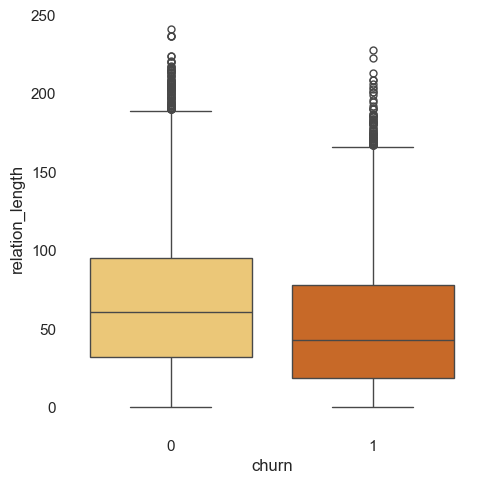

In [58]:
sns.catplot(data=energy_supplier, x="churn", y="relation_length", kind="box", palette='YlOrBr')
plt.gca().set_facecolor('none')#set boxplot background to be transparent)
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent)

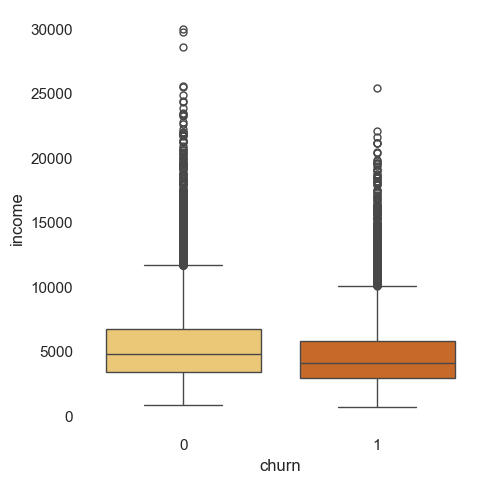

In [59]:
sns.catplot(data=energy_supplier, x="churn", y="income", kind="box", palette='YlOrBr')
plt.gca().set_facecolor('none')#set boxplot background to be transparent)
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent)

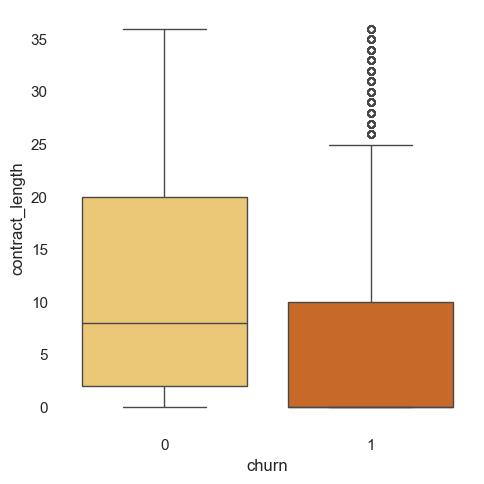

In [60]:
sns.catplot(data=energy_supplier, x="churn", y="contract_length", kind="box", palette='YlOrBr')
plt.gca().set_facecolor('none')#set boxplot background to be transparent)
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent)

<Axes: xlabel='contract_length', ylabel='Count'>

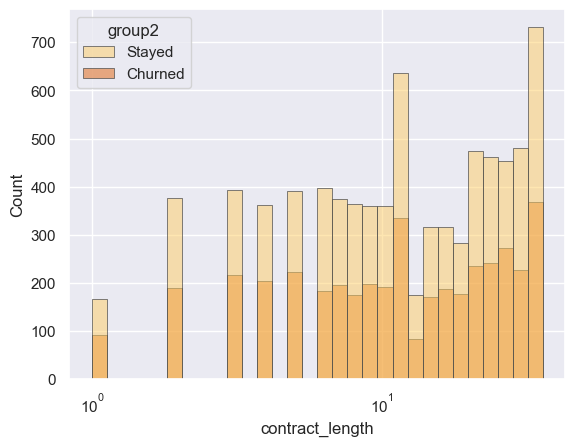

In [61]:
# Graph
energy_supplier['group2'] = energy_supplier['churn'].apply(lambda x: 'Churned' if x in [1] else 'Stayed')
sns.histplot(
    energy_supplier.loc[energy_supplier['contract_length']>0,:],
    x="contract_length", hue="group2",
    multiple="layer",
    palette="YlOrBr",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,)

- Those who do not churn have on average a longer existing relationship with the energy provider 
- Those who do not churn have on average a greater income than those wo do. 
- Those who do churn have on average a shorter contract, and assumingly a lesser fine to pay than those who do not 

#### 4.3.6 Churn - Start Channel

In [62]:
from scipy.stats import chi2_contingency

# Create a contingency table (cross-tabulation) between 'churn' and 'start_channel'
contingency_table = pd.crosstab(energy_supplier['churn'], energy_supplier['start_channel'])

stat, p, dof, expected = chi2_contingency(contingency_table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('No significant association between the variables')
else:
	print('Significant association between the variables')

stat=390.065, p=0.000
Significant association between the variables


Text(0, 0.5, 'Churn')

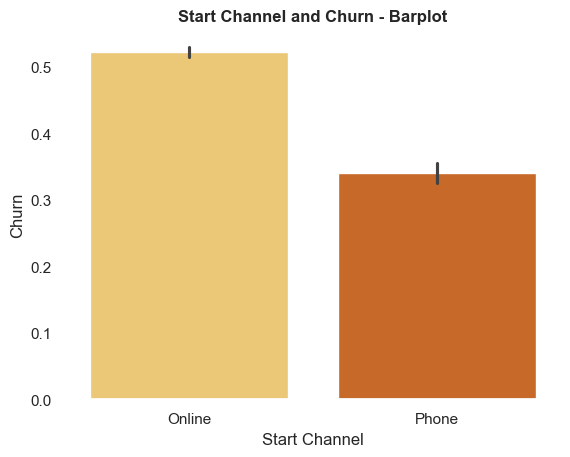

In [63]:
sns.barplot(x='start_channel', y='churn', data=energy_supplier,  palette='YlOrBr')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent
plt.title('Start Channel and Churn - Barplot', fontweight='bold')
plt.xlabel('Start Channel')
plt.ylabel('Churn')

#### 4.3.7 Churn - Province

In [64]:
contingency_table = pd.crosstab(energy_supplier['churn'], energy_supplier['province'])

stat, p, dof, expected = chi2_contingency(contingency_table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('No significant association between the variables')
else:
	print('Significant association between the variables')

stat=88.325, p=0.000
Significant association between the variables


#### 4.3.8 Churn - Gender

In [65]:
contingency_table = pd.crosstab(energy_supplier['churn'], energy_supplier['gender'])

stat, p, dof, expected = chi2_contingency(contingency_table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('No significant association between the variables')
else:
	print('Significant association between the variables')

stat=10.765, p=0.001
Significant association between the variables


/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_34476/4060087757.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Male', 'Female'])


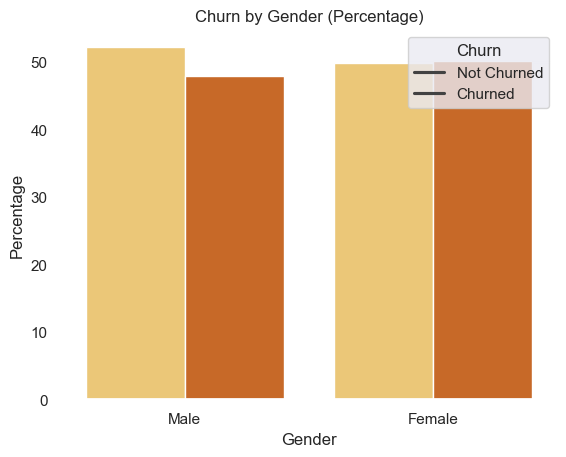

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the percentage of churned and non-churned customers by gender
churn_percentages = energy_supplier.groupby('gender')['churn'].value_counts(normalize=True).unstack() * 100

# Reset index to make 'gender' a column again
churn_percentages = churn_percentages.reset_index()

# Melt the DataFrame to long format for seaborn
melted_percentages = churn_percentages.melt(id_vars='gender', var_name='Churn', value_name='Percentage')

# Plot the grouped barplot with percentages using seaborn
ax = sns.barplot(x='gender', y='Percentage', hue='Churn', data=melted_percentages, palette='YlOrBr')

# Add labels and title
plt.title('Churn by Gender (Percentage)')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent
# Manually set xticks labels
ax.set_xticklabels(['Male', 'Female'])

# Show the plot
plt.show()


## 5. Classification Models

### 5.1 Logistic Regression

In [103]:
#we define the independent and dependent variables
X = energy_supplier[['gender', 'age', 'income', 'relation_length', 'electricity_usage','gas_usage','e_start_channel', 'contract']]
y = energy_supplier['churn']

In [104]:
#we split the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25, random_state=1234)

In [105]:
'''we create an instance of the logistic regression model.
An instance has all the methods and attributes associated with the logistic regression class, like fit, predict or coef'''
logit = LogisticRegression(max_iter=1000)

In [106]:
#here we train de model with the train dataset.
#when you run logit.fit(X_train, y_train), the trained logistic regression model is stored within the logit object.
logit.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [100]:
#Now we do predictions with the train model in the test dataset
y_pred = logit.predict(X_test)

In [101]:
# Now we calculate the accuracy of the logistic regression model. It internally makes predictions using the x_test dataset and compares the
#prediction with the actual labels in y_test (comparing y_pred with y_test)
score = logit.score(X_test, y_test)
print("Accuracy: ", score)

Accuracy:  0.7506


In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      2549
           1       0.76      0.72      0.74      2451

    accuracy                           0.75      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.75      0.75      0.75      5000



### 5.2 KNN (Introduccion_a_algoritmos_de_clasificacion - En modulo 3 Apredizaje supervisado clasificado)

In [166]:
#Parameters
weights = 'distance'
p = 2
n_neighbours = 10
#Model
KNN = KNeighborsClassifier(n_neighbors = n_neighbours, weights = weights, p = p)

KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2549
           1       0.62      0.63      0.62      2451

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.63      5000
weighted avg       0.63      0.63      0.63      5000



### 5.3 SVM - Support Vector Machine

In [167]:
from sklearn import svm

# Initialize SVM classifier
SVC = svm.SVC(kernel='linear', C=0.1)

# Train the SVM model
SVC.fit(X_train, y_train)

# Make predictions on the test set
y_pred = SVC.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Accuracy: 0.7432
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      2549
           1       0.75      0.71      0.73      2451

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000



### 5.4 Decision Tree Model

We use OneHotEncoder to convert the categorical variable Province into a binary format, due to the nature of this study algorithms that require numerical input will be used and through one hot encoding we can treat the categories in Province as independet entities, such as Logistic Regression

In [ ]:
#we fit the unique categories in Province and prepare the encoder for transformation
encoder = OneHotEncoder().fit(energy_supplier[['province']])
#we create a dataframe using the fitted encoder, where each province is a column 
enc_province = pd.DataFrame(encoder.transform(energy_supplier[['province']]).toarray(), columns = encoder.categories_[0].tolist())
#both dataframes are concatenated and simultaneously the province variable is dropped 
energy_supplier = pd.concat([energy_supplier, enc_province], axis = 1)
energy_supplier = energy_supplier.drop(['province'], axis = 1)
'''
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(energy_supplier[['province']]).toarray()
column_names = encoder.get_feature_names_out()
onehot_name_df = pd.DataFrame(data=encoded_data, columns=column_names)
onehot_name_df.head()
'''

In [111]:
X = energy_supplier.drop(columns=['churn', 'log_income', 'customer_id','group1','group2','home_label','start_channel','home_age_c'])
y = energy_supplier['churn']

In [112]:
#we split the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25, random_state=1234)

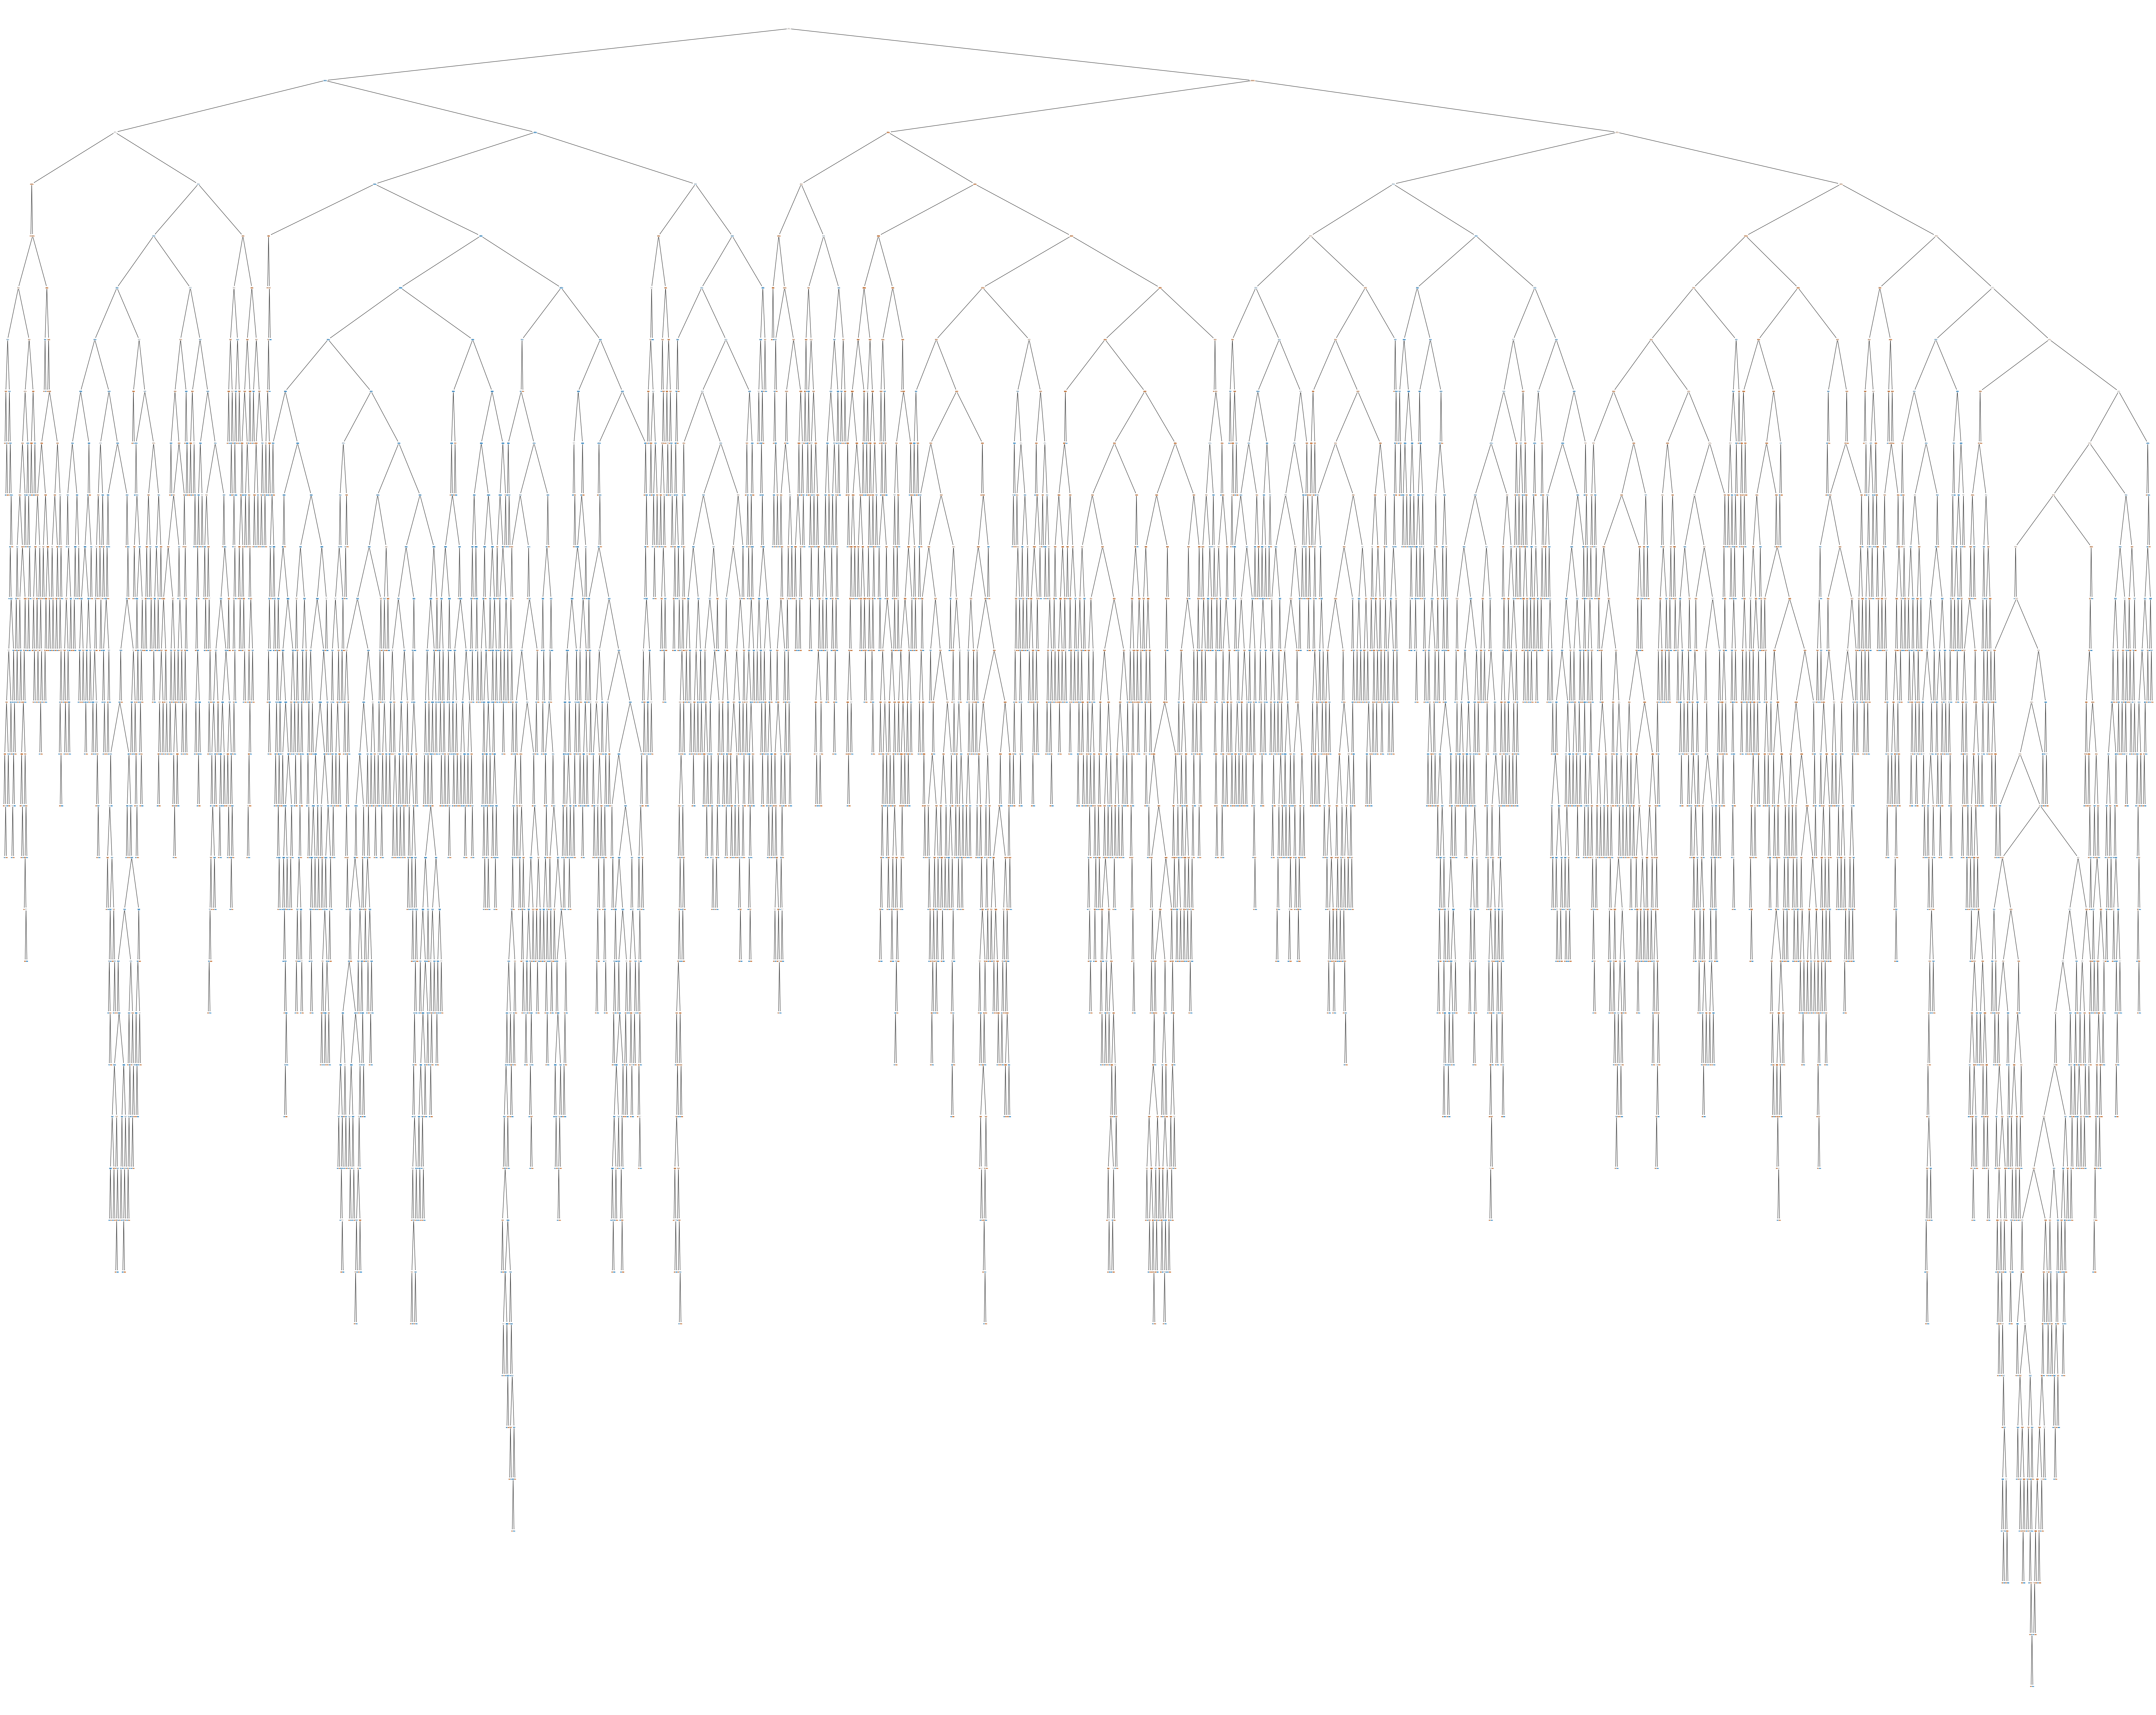

In [113]:
plt.figure(figsize = (100,80))
DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)
plot_tree(DTC, filled=True)
plt.show()

In [114]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67      2549
           1       0.66      0.65      0.65      2451

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000



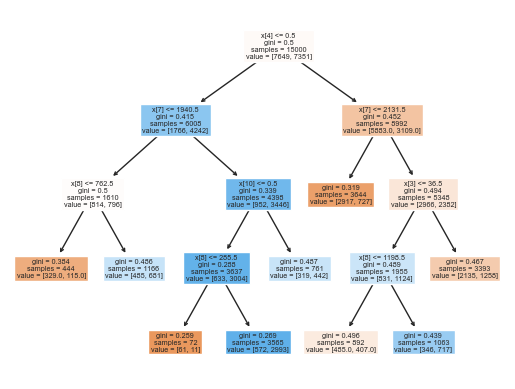

In [115]:
#Change paragrams 
params1 = {
    'min_samples_split': 100,
    'min_samples_leaf': 50,
    'ccp_alpha': 0.003,
    'max_depth': 30
}

DTC1 = DecisionTreeClassifier(**params1)
DTC1.fit(X_train, y_train)
y_pred = DTC1.predict(X_test)
plot_tree(DTC1, filled=True)
plt.show()

In [116]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      2549
           1       0.75      0.64      0.69      2451

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



### 5.5 Random Forrest

In [168]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
y_preds = RFC.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.73      0.78      0.76      2549
           1       0.76      0.71      0.73      2451

    accuracy                           0.74      5000
   macro avg       0.75      0.74      0.74      5000
weighted avg       0.75      0.74      0.74      5000

